# Importing Library

In [ ]:
# Ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import re
import sys
import zipfile
import datetime
import time
import glob
import subprocess

from shutil import move, copy, make_archive

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from scipy.interpolate import make_interp_spline

# Import TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2, InceptionV3, Xception, VGG16, VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

# Mount Google Drive in Colab
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check Libraries Version
print("Python version:", sys.version)
print("TensorFlow version:", tf.__version__)
import keras
print("Keras version:", keras.__version__)
import matplotlib
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
import sklearn
print("scikit-learn version:", sklearn.__version__)
import scipy
print("SciPy version:", scipy.__version__)

Python version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
TensorFlow version: 2.17.1
Keras version: 3.5.0
Matplotlib version: 3.8.0
Seaborn version: 0.13.2
NumPy version: 1.26.4
Pandas version: 2.2.2
scikit-learn version: 1.5.2
SciPy version: 1.13.1


In [ ]:
# Set base model
# base_model = "MobileNetV2"
# base_model = "Xception"
base_model = "InceptionV3"
# base_model = "VGG16"
# base_model = "VGG19"

# Set image size and input shape
if base_model in ["Xception", "InceptionV3"]:
    img_size = (299, 299)
    input_shape = (299, 299, 3)
else:
    img_size = (224, 224)
    input_shape = (224, 224, 3)

width, height = img_size

# Set batch size and number of classes
batch_size = 256
num_classes = 52

# Download n Extract Dataset

In [ ]:
# Run shell commands
def run_command(command):
    subprocess.run(command, shell=True, check=True)

# Download and extract dataset from a URL
def load_dataset(url, unzip=True, remove_after_unzip=True, dest_dir=None):

    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    # Handle downloading from Google Drive
    if 'drive.google.com' in url:
        print(f'Downloading from Google Drive: {url}')
        file_id = url.split('/')[-2]
        run_command(f"gdown --id {file_id}")

    # Handle downloading from Kaggle
    elif 'kaggle.com' in url:
        print(f'Downloading from Kaggle: {url}')
        file_id = url.split("kaggle.com/datasets/")[1]
        run_command(f"kaggle datasets download -d {file_id}")

    # Handle downloading from GitHub (ZIP file)
    elif 'github.com' in url and url.endswith('.zip'):
        print(f'Downloading from GitHub: {url}')
        run_command(f"wget {url}")

    # Raise error if URL format is unsupported
    else:
        raise ValueError("URL format is not supported. Please provide a valid Google Drive, Kaggle, or GitHub URL.")

    zip_file_path = max(glob.glob('/content/*.zip'))

    # Extract the downloaded ZIP file
    if unzip:
        print(f'Extracting {zip_file_path}...')
        try:
            if zip_file_path.endswith('.zip'):
                with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                    zip_ref.extractall(dest_dir)
            else:
                raise ValueError(f"{zip_file_path} is not a valid zip file..")
        except Exception as e:
            print(f"An error occurred while extracting the file: {e}")
        finally:
            # Remove the ZIP file after extraction
            if remove_after_unzip:
                print(f'Removing {zip_file_path}...')
                os.remove(zip_file_path)

In [ ]:
# base_dir = "/content/dataset_zip"
# load_dataset('https://www.kaggle.com/datasets/ravyardiankusuma/motif-batik-indonesia-fix', dest_dir=base_dir)

Extracting /content/motif-batik-indonesia-fix.zip...
Removing /content/motif-batik-indonesia-fix.zip...


In [ ]:
base_dir = "/content/dataset"
load_dataset('https://drive.google.com/file/d/1xiiQ-ECnEmZM33LKiGaOsRzVU2qoByRk/view?usp=sharing', dest_dir=base_dir)

Extracting /content/dataset.zip...
Removing /content/dataset.zip...


# Preprocessing the Data into Tabular DataFrame

In [ ]:
# Format class label by splitting the region and motif
def format_class_label(label):
    region, motif = label.split("_", 1)

    def split_words(word):
        return re.sub(r'([a-z])([A-Z])', r'\1 \2', word)

    region = split_words(region)
    motif = split_words(motif)

    return region, motif

In [ ]:
data = []

# Loop to create a tabular DataFrame
for folder_name in sorted(os.listdir(base_dir)):
    folder_path = os.path.join(base_dir, folder_name)
    if os.path.isdir(folder_path):
        try:
            region, motif = format_class_label(folder_name)
        except ValueError:
            continue

        file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

        data.append([motif, region, file_count])

df = pd.DataFrame(data, columns=["Motif Name", "Region Name", "Number of Photos"])

print(df)

            Motif Name       Region Name  Number of Photos
0               Barong              Bali              1000
1                Merak              Bali              1000
2          Ondel Ondel           Jakarta              1000
3               Tumpal           Jakarta              1000
4          Megamendung        Jawa Barat              1000
5           Asem Arang       Jawa Tengah              1000
6           Asem Sinom       Jawa Tengah              1000
7           Asem Warak       Jawa Tengah              1000
8               Blekok       Jawa Tengah              1000
9         Blekok Warak       Jawa Tengah              1000
10            Cipratan       Jawa Tengah              1000
11  Gambang Semarangan       Jawa Tengah              1000
12         Ikan Kerang       Jawa Tengah              1000
13       Jagung Lombok       Jawa Tengah              1000
14     Jambu Belimbing       Jawa Tengah              1000
15         Jambu Citra       Jawa Tengah              10

# Splitting Dataset into Train, Validation, Test

In [ ]:
# Split dataset into train, validation, and test sets
def split_data(base_dir, output_dir, train_size=0.8, val_size=0.1, test_size=0.1,
               random_state=42, save_zip=False, save_drive=False):

    print(f"Splitting dataset into train {int(train_size*100)}%, validation {int(val_size*100)}%, and test {int(test_size*100)}%")

    os.makedirs(output_dir, exist_ok=True)
    for split in ['train', 'validation', 'test']:
        split_path = os.path.join(output_dir, split)
        os.makedirs(split_path, exist_ok=True)

    motif_folders = os.listdir(base_dir)

    for motif_folder in motif_folders:
        motif_path = os.path.join(base_dir, motif_folder)
        images = os.listdir(motif_path)

        # Split the images into train, validation, and test sets
        train_images, temp_images = train_test_split(images, train_size=train_size, random_state=random_state)
        val_images, test_images = train_test_split(temp_images, train_size=val_size/(1-train_size), random_state=random_state)

        for split, split_images in zip(['train', 'validation', 'test'], [train_images, val_images, test_images]):
            split_motif_dir = os.path.join(output_dir, split, motif_folder)
            os.makedirs(split_motif_dir, exist_ok=True)

            # Copy image files to the appropriate split directory
            for image_file in split_images:
                src_image_path = os.path.join(motif_path, image_file)
                dst_image_path = os.path.join(split_motif_dir, image_file)
                copy(src_image_path, dst_image_path)

    print("The dataset was successfully split into train, validation, and test folders!")

    # Create a zip archive of the dataset
    if save_zip:
        zip_file_name = 'dataset.zip'
        make_archive(zip_file_name.replace('.zip',''), 'zip', output_dir)
        print(f"ZIP file successfully created: {zip_file_name}")

        # Move the zip file to Google Drive
        if save_drive:
            destination_path = '/content/drive/My Drive/' + zip_file_name
            move(zip_file_name, destination_path)
            print(f"File successfully moved to Google Drive at: {destination_path}")

In [ ]:
base_dir = "/content/dataset_zip"
output_dir = "/content/dataset"
split_data(base_dir, output_dir, save_zip=True, save_drive=True)

Splitting dataset into train 80%, validation 10%, and test 10%
The dataset was successfully split into train, validation, and test folders!
ZIP file successfully created: dataset.zip
File successfully moved to Google Drive at: /content/drive/My Drive/dataset.zip


In [ ]:
# Count the number of images in each split (train, validation, test)
train_count = sum(len(files) for _, _, files in os.walk(os.path.join(output_dir, 'train')))
val_count = sum(len(files) for _, _, files in os.walk(os.path.join(output_dir, 'validation')))
test_count = sum(len(files) for _, _, files in os.walk(os.path.join(output_dir, 'test')))

print(f"Train images: {train_count}, Validation images: {val_count}, Test images: {test_count}")

Train images: 41600, Validation images: 5200, Test images: 5200


# Data Augmentation

In [ ]:
def augmentation(train_dir, val_dir, test_dir, img_size=None, batch_size=None,
                 rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                 shear_range=0.2, zoom_range=0.2, horizontal_flip=True):

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        shear_range=shear_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip,
        fill_mode="nearest"
    )

    val_test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical"
    )
    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical"
    )
    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False
    )

    print("Data preprocessing is complete and the generator is ready to use!")
    return train_generator, val_generator, test_generator

In [ ]:
train_dir = "/content/dataset/train"
val_dir = "/content/dataset/validation"
test_dir = "/content/dataset/test"
train_generator, val_generator, test_generator = augmentation(
    train_dir,
    val_dir,
    test_dir,
    img_size=img_size,
    batch_size=batch_size
)

Found 41600 images belonging to 52 classes.
Found 5200 images belonging to 52 classes.
Found 5200 images belonging to 52 classes.
Data preprocessing is complete and the generator is ready to use!


# Define the Score function

In [ ]:
def plot_learning_curves(epochs, train_acc, val_acc, train_loss, val_loss, file_name):
    x = np.array(epochs)
    x_smooth = np.linspace(x.min(), x.max(), 500)

    train_acc_smooth = make_interp_spline(x, train_acc)(x_smooth)
    val_acc_smooth = make_interp_spline(x, val_acc)(x_smooth)

    train_loss_smooth = make_interp_spline(x, train_loss)(x_smooth)
    val_loss_smooth = make_interp_spline(x, val_loss)(x_smooth)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot Accuracy
    axes[0].plot(x_smooth, train_acc_smooth, 'r-', label='Training Accuracy')
    axes[0].plot(x_smooth, val_acc_smooth, 'g-', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy', fontsize=14)
    axes[0].set_xlabel('Epochs', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(loc='best', fontsize=10)
    axes[0].set_ylim((0, 1.05))
    axes[0].grid(True)

    # Plot Loss
    axes[1].plot(x_smooth, train_loss_smooth, 'r-', label='Training Loss')
    axes[1].plot(x_smooth, val_loss_smooth, 'g-', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss', fontsize=14)
    axes[1].set_xlabel('Epochs', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(loc='best', fontsize=10)
    axes[1].grid(True)

    fig.savefig(file_name)

    plt.tight_layout()
    plt.show()

In [ ]:
def scoring(model, train_generator, val_generator, test_generator,
            return_type="all", plot_path=None, history=None):

    results = {}

    test_generator.reset()
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    # 1. Evaluation
    if return_type in ['evaluation', 'eval', 'evaluate', 'all']:
        print("Evaluating the model on validation data...")
        val_loss, val_acc = model.evaluate(val_generator)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        results['val_loss'] = val_loss
        results['val_accuracy'] = val_acc

        print("\nEvaluating the model on test data...")
        test_loss, test_acc = model.evaluate(test_generator)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
        results['test_loss'] = test_loss
        results['test_accuracy'] = test_acc

    # 2. Plotting Accuracy and Loss
    if return_type in ['plot', 'all']:
        train_acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(train_acc))
        plot_learning_curves(epochs, train_acc, val_acc, train_loss, val_loss, plot_path)
        results['plot_path'] = plot_path

    # 3. Confusion Matrix
    if return_type in ['confusion_matrix', 'cm', 'all']:
        print("Generating confusion matrix...")
        test_pred = model.predict(test_generator)
        test_pred_classes = np.argmax(test_pred, axis=1)
        cm = confusion_matrix(true_classes, test_pred_classes)

        plt.figure(figsize=(18, 16))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels,
                    yticklabels=class_labels, cbar=False)
        plt.title('Confusion Matrix', fontsize=18)
        plt.xlabel('Predicted Label', fontsize=14)
        plt.ylabel('True Label', fontsize=14)
        plt.xticks(rotation=90, fontsize=12)
        plt.yticks(rotation=0, fontsize=12)
        plt.tight_layout()
        plt.savefig(plot_path)
        plt.show()

        results['confusion_matrix'] = cm

    # 4. Classification Report
    if return_type in ['classification_report', 'cr', 'all']:
        print("Classification Report:\n")
        test_pred = model.predict(test_generator)
        test_pred_classes = np.argmax(test_pred, axis=1)
        class_report = classification_report(true_classes, test_pred_classes, target_names=class_labels)
        print(class_report)
        results['classification_report'] = class_report

    # 5. Predictions
    if return_type in ['prediction', 'pred', 'predict', 'all']:
        print("Making predictions on test data...")
        test_pred = model.predict(test_generator)
        test_pred_classes = np.argmax(test_pred, axis=1)
        acc_score = accuracy_score(true_classes, test_pred_classes)
        print(f"Accuracy on test data: {acc_score:.4f}")
        results['test_predictions'] = test_pred_classes

    # 6. Statistics
    if return_type in ["statistics", "stat", "all"]:
        print("Calculating statistics...")
        test_pred = model.predict(test_generator)
        test_pred_classes = np.argmax(test_pred, axis=1)
        cm = confusion_matrix(true_classes, test_pred_classes)

        correct_per_class = np.diag(cm)
        total_per_class = np.sum(cm, axis=1)
        incorrect_per_class = total_per_class - correct_per_class
        accuracy_per_class = (correct_per_class / total_per_class) * 100

        results_df = pd.DataFrame({
            'Category': class_labels,
            'Correct': correct_per_class,
            'Incorrect': incorrect_per_class,
            'Accuracy (%)': accuracy_per_class
        })

        print("\nPer-class Results:\n", results_df)
        results['per_class_results'] = results_df

    return results

# Define Callbacks

In [ ]:
def get_callbacks(base_model_name, fine_tune):
    if fine_tune:
        base_model_name = f"FineTuned_{base_model_name}"
    else:
        base_model_name = f"Pretrained_{base_model_name}"

    model_checkpoint = ModelCheckpoint(
        f'Best_{base_model_name}_Model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    csv_logger = CSVLogger(
        f'{base_model_name}_Training_Log.csv',
        append=True
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        verbose=1,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )

    return [model_checkpoint, csv_logger, early_stopping, reduce_lr]

# Define the Model

In [ ]:
def trainable_model(base_model_name, train_generator, val_generator, input_shape=None,
                    dropout1=0.3, dropout2=0.3, dropout3=0.3, dense_units1=256, dense_units2=256,
                    num_classes=None, learning_rate=1e-3, include_top=False, fine_tune=False,
                    show_summary=False, epochs=None, verbose=0, pretrained_model=None, initial_epoch=0):

    if base_model_name.lower() == "mobilenetv2":
        base_model = MobileNetV2(input_shape=input_shape,
                                 include_top=include_top,
                                 weights="imagenet")
    elif base_model_name.lower() == "xception":
        base_model = Xception(input_shape=input_shape,
                              include_top=include_top,
                              weights="imagenet")
    elif base_model_name.lower() == "inceptionv3":
        base_model = InceptionV3(input_shape=input_shape,
                                 include_top=include_top,
                                 weights="imagenet")
    elif base_model_name.lower() == "vgg16":
        base_model = VGG16(input_shape=input_shape,
                           include_top=include_top,
                           weights="imagenet")
    elif base_model_name.lower() == "vgg19":
        base_model = VGG19(input_shape=input_shape,
                           include_top=include_top,
                           weights="imagenet")
    else:
        raise ValueError("Invalid base_model_name. Choose from 'mobilenetv2', 'xception', 'inceptionv3', 'vgg16', 'vgg19'.")

    if fine_tune:
        model = pretrained_model
        print(f"Pretrained model loaded.")
        base_model = model.layers[0]
        base_model.trainable = False

        total_layers = len(base_model.layers)
        layers_to_unfreeze = int(total_layers * 0.6)
        for layer in base_model.layers[layers_to_unfreeze:]:
            layer.trainable = True
        print(f"Fine-tuning enabled: Out of {total_layers} layers, the last {total_layers - layers_to_unfreeze} layers will be trained.")
    else:
        base_model.trainable = False
        print("Fine-tuning disabled: Base model will not be trained.")

        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dropout(dropout1),
            Dense(dense_units1, activation="relu"),
            Dropout(dropout2),
            Dense(dense_units2, activation="relu"),
            Dropout(dropout3),
            Dense(num_classes, activation="softmax")
        ])

    if show_summary:
        model.summary()

        plot_model(
            model,
            show_shapes=True,
            show_layer_names=True,
            to_file=f"{base_model_name}_Model_Plot.png"
        )
        plt.close()
        print(f"Model plot saved at {base_model_name}_Model_Plot.png\n")

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    now = datetime.datetime.now
    t = now()
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs+initial_epoch,
        initial_epoch=initial_epoch,
        callbacks=get_callbacks(base_model_name, fine_tune),
        verbose=verbose
    )
    print('Training time: %s' % (now() - t))

    return model, history

# Training Pretrained Model

In [ ]:
!apt-get -qq install -y graphviz && pip install -q pydot

In [ ]:
model, history = trainable_model(
    base_model,
    train_generator,
    val_generator,
    input_shape=input_shape,
    num_classes=num_classes,
    show_summary=True,
    epochs=10,
    verbose=1
)

model.save(f'Final_Pretrained_{base_model}_Model.keras')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Fine-tuning disabled: Base model will not be trained.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 8, 8, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 52)                  │          13,364 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,406,484 (85.47 MB)

 Trainable params: 603,700 (2.30 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Model plot saved at InceptionV3_Model_Plot.png

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3009 - loss: 2.8106
Epoch 1: val_loss improved from inf to 0.59119, saving model to Best_Pretrained_InceptionV3_Model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 1159s 6s/step - accuracy: 0.3020 - loss: 2.8054 - val_accuracy: 0.8354 - val_loss: 0.5912 - learning_rate: 0.0010
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7264 - loss: 0.9455
Epoch 2: val_loss improved from 0.59119 to 0.35771, saving model to Best_Pretrained_InceptionV3_Model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 1014s 6s/step - accuracy: 0.7266 - loss: 0.9450 - val_accuracy: 0.9008 - val_loss: 0.3577 - learning_rate: 0.0010
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7946 - loss: 0.6875
Epoch 3: val_loss improved from 0.35771 to 0.24296, saving model to Best_Pretrained_InceptionV3_Model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 1000s 6s/step - accuracy: 0.7947 - loss: 0.6873 - val_accuracy: 0.9302 - val_loss: 0.2430 - learning_rate: 0.0010
Epoch 4

# Scoring Pretrained Model

In [ ]:
# Evaluating the model
results_eval = scoring(model, train_generator, val_generator, test_generator, return_type='eval')

Evaluating the model on validation data...
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9805 - loss: 0.0804
Validation Loss: 0.0838, Validation Accuracy: 0.9781

Evaluating the model on test data...
21/21 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9824 - loss: 0.0615
Test Loss: 0.0753, Test Accuracy: 0.9783


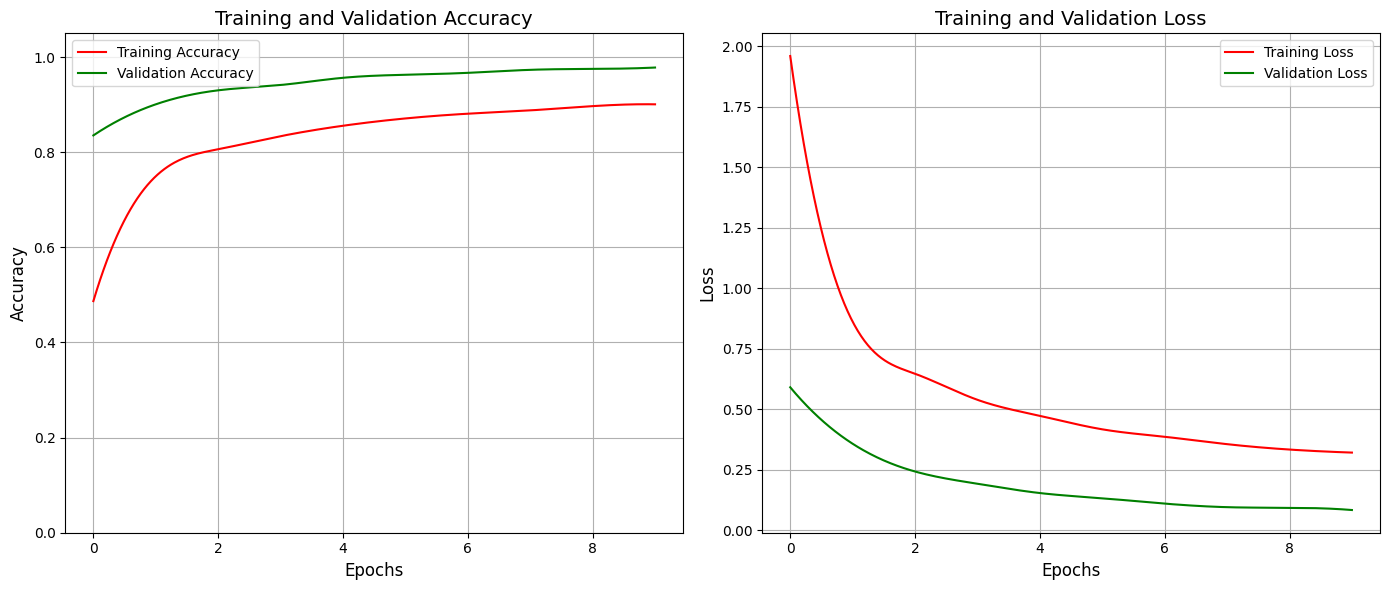

In [ ]:
# Plot Accuracy and Loss
results_plot = scoring(
    model, train_generator, val_generator, test_generator, return_type='plot',
    plot_path=f'Pretrained_{base_model}_Plot_Accuracy_Loss.png', history=history
)

Generating confusion matrix...
21/21 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step


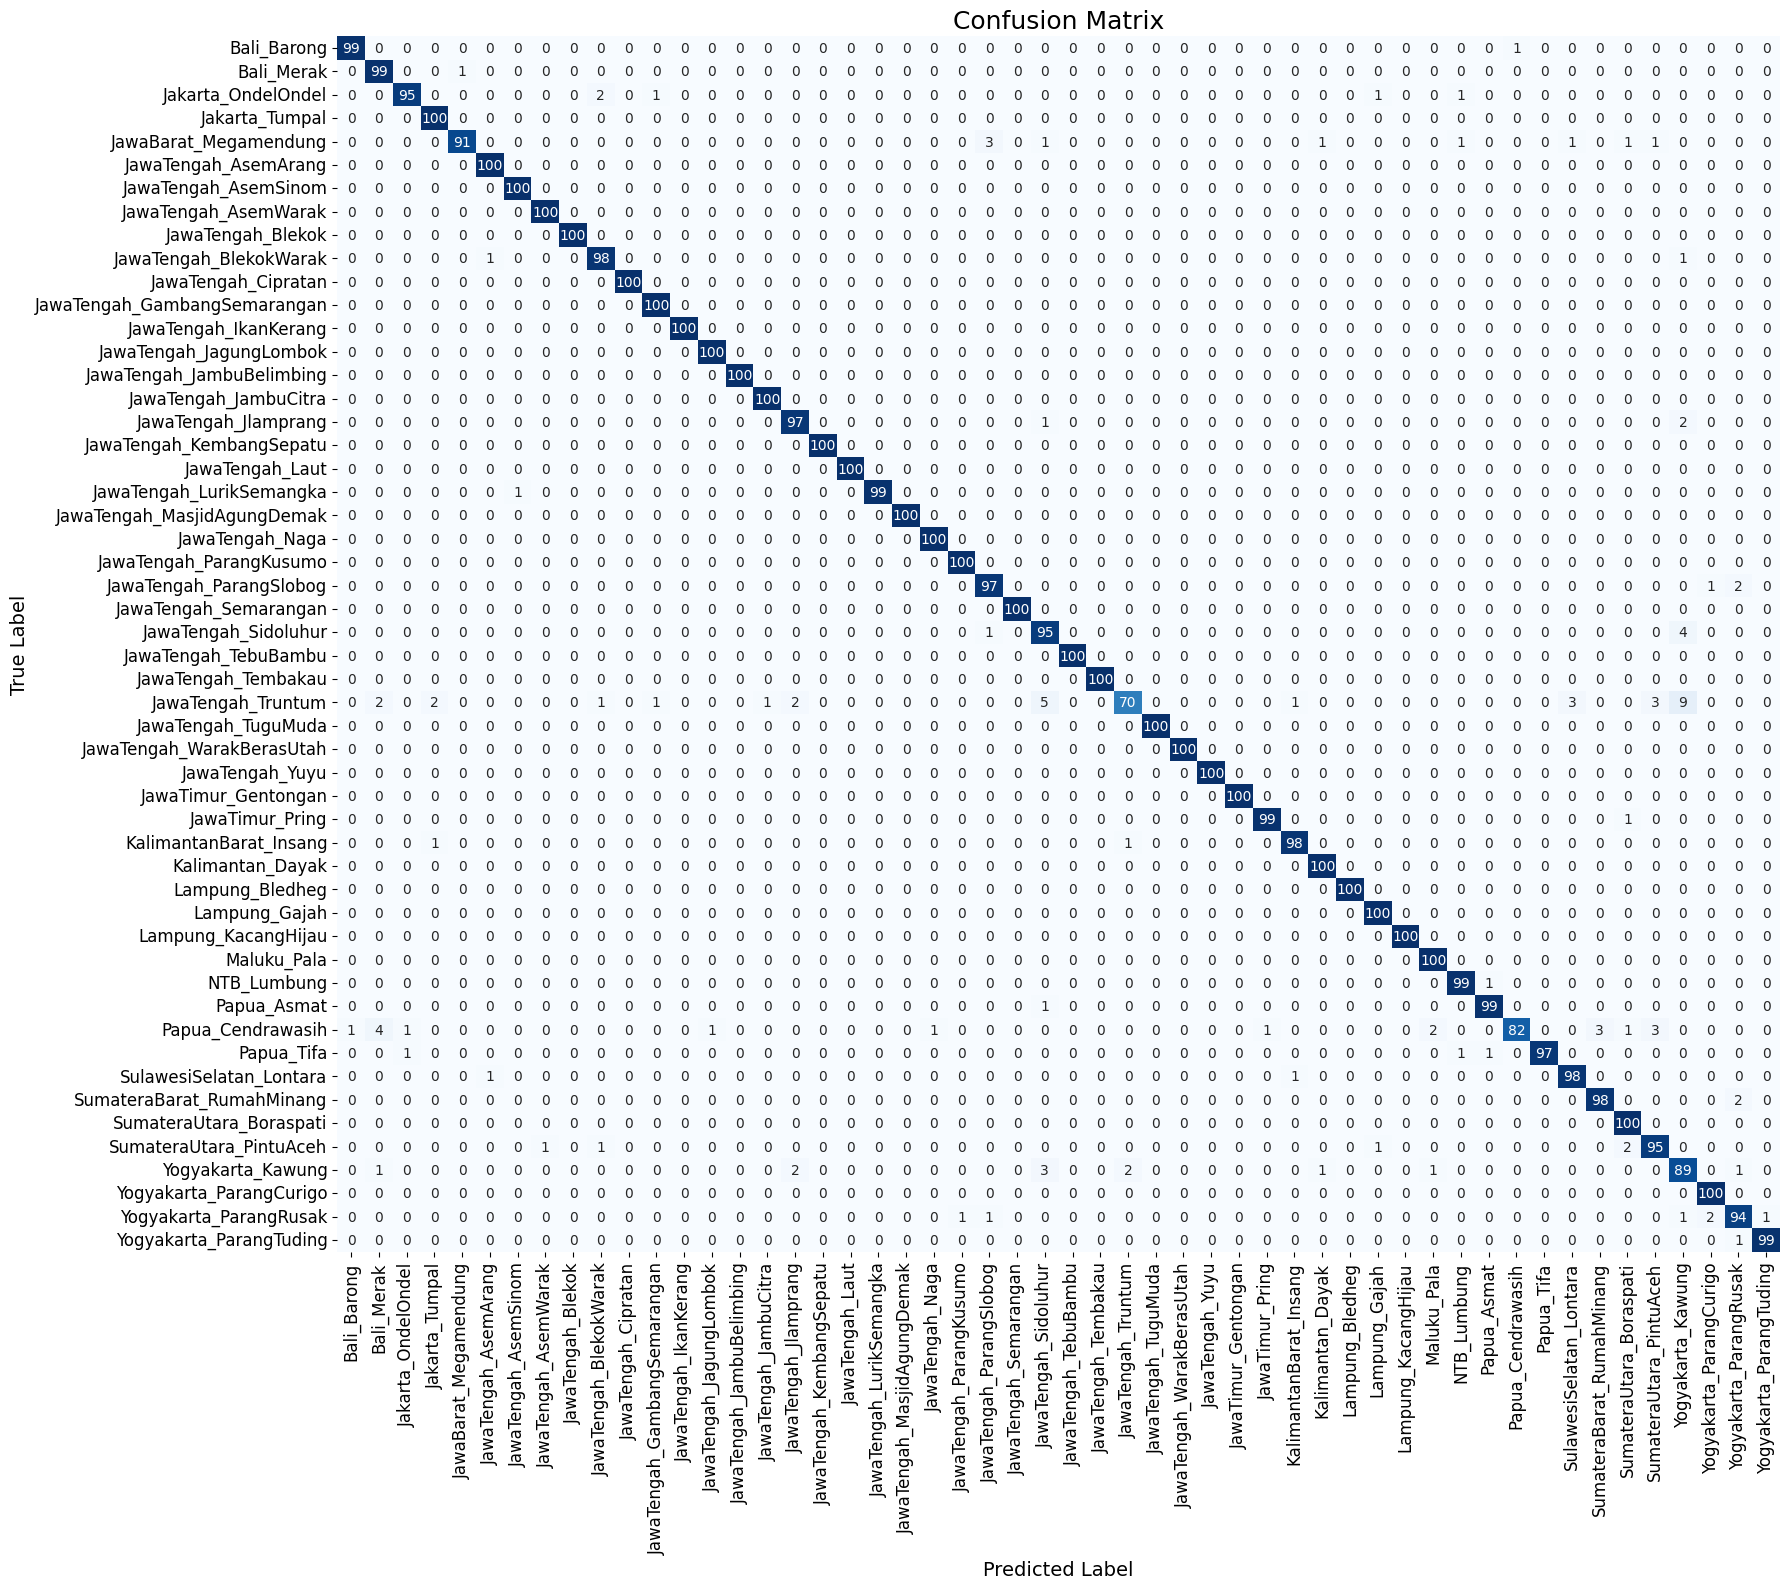

In [ ]:
# Confusion Matrix
results_cm = scoring(model, train_generator, val_generator, test_generator, return_type='cm', plot_path=f'Pretrained_{base_model}_Confusion_Matrix.png')

In [ ]:
# Classification Report
results_cr = scoring(model, train_generator, val_generator, test_generator, return_type='cr')

Classification Report:

21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 986ms/step
                              precision    recall  f1-score   support

                 Bali_Barong       0.99      0.99      0.99       100
                  Bali_Merak       0.93      0.99      0.96       100
          Jakarta_OndelOndel       0.98      0.95      0.96       100
              Jakarta_Tumpal       0.97      1.00      0.99       100
       JawaBarat_Megamendung       0.99      0.91      0.95       100
        JawaTengah_AsemArang       0.98      1.00      0.99       100
        JawaTengah_AsemSinom       0.99      1.00      1.00       100
        JawaTengah_AsemWarak       0.99      1.00      1.00       100
           JawaTengah_Blekok       1.00      1.00      1.00       100
      JawaTengah_BlekokWarak       0.96      0.98      0.97       100
         JawaTengah_Cipratan       1.00      1.00      1.00       100
JawaTengah_GambangSemarangan       0.98      1.00      0.99       100
       JawaTengah_IkanK

In [ ]:
# Predictions
results_predict = scoring(model, train_generator, val_generator, test_generator, return_type='pred')

Making predictions on test data...
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step
Accuracy on test data: 0.9783


In [ ]:
# Statistics
results_stats = scoring(model, train_generator, val_generator, test_generator, return_type='stat')

Calculating statistics...
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 986ms/step

Per-class Results:
                         Category  Correct  Incorrect  Accuracy (%)
0                    Bali_Barong       99          1          99.0
1                     Bali_Merak       99          1          99.0
2             Jakarta_OndelOndel       95          5          95.0
3                 Jakarta_Tumpal      100          0         100.0
4          JawaBarat_Megamendung       91          9          91.0
5           JawaTengah_AsemArang      100          0         100.0
6           JawaTengah_AsemSinom      100          0         100.0
7           JawaTengah_AsemWarak      100          0         100.0
8              JawaTengah_Blekok      100          0         100.0
9         JawaTengah_BlekokWarak       98          2          98.0
10           JawaTengah_Cipratan      100          0         100.0
11  JawaTengah_GambangSemarangan      100          0         100.0
12         JawaTengah_IkanKerang      10

In [ ]:
# results_all = scoring(model, train_generator, val_generator, test_generator, return_type='all')

# Training FineTuning Model

In [ ]:
def get_initial_epoch_from_csv(csv_file_path):
    df = pd.read_csv(csv_file_path)

    initial_epoch = len(df['epoch']) if not df.empty else 0

    print(f"Initial epoch: {initial_epoch}")
    return initial_epoch

csv_file_path = f'Pretrained_{base_model}_Training_Log.csv'
initial_epoch = get_initial_epoch_from_csv(csv_file_path)

Initial epoch: 10


In [ ]:
model_finetune, history_finetune = trainable_model(
    base_model,
    train_generator,
    val_generator,
    input_shape=input_shape,
    num_classes=num_classes,
    learning_rate=1e-4,
    show_summary=True,
    epochs=10,
    verbose=1,
    fine_tune=True,
    pretrained_model=model,
    initial_epoch=initial_epoch
)

model_finetune.save(f'Final_FineTuned_{base_model}_Model.keras')

Pretrained model loaded.
Fine-tuning enabled: Out of 311 layers, the last 125 layers will be trained.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 8, 8, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 52)                  │          13,364 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,613,886 (90.08 MB)

 Trainable params: 15,918,900 (60.73 MB)

 Non-trainable params: 6,487,584 (24.75 MB)

 Optimizer params: 1,207,402 (4.61 MB)

Model plot saved at InceptionV3_Model_Plot.png

Epoch 11/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8663 - loss: 0.4766
Epoch 11: val_loss improved from inf to 0.02064, saving model to Best_FineTuned_InceptionV3_Model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 1144s 6s/step - accuracy: 0.8667 - loss: 0.4751 - val_accuracy: 0.9940 - val_loss: 0.0206 - learning_rate: 1.0000e-04
Epoch 12/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9855 - loss: 0.0486
Epoch 12: val_loss improved from 0.02064 to 0.01352, saving model to Best_FineTuned_InceptionV3_Model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 1047s 6s/step - accuracy: 0.9855 - loss: 0.0486 - val_accuracy: 0.9971 - val_loss: 0.0135 - learning_rate: 1.0000e-04
Epoch 13/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9917 - loss: 0.0250
Epoch 13: val_loss improved from 0.01352 to 0.00903, saving model to Best_FineTuned_InceptionV3_Model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 1110s 6s/step - accuracy: 0.9917 - loss: 0.0250 - v

# Scoring FineTuned Model

In [ ]:
# Evaluating the model
results_eval_finetune = scoring(model_finetune, train_generator, val_generator, test_generator, return_type='eval')

Evaluating the model on validation data...
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9999 - loss: 0.0019
Validation Loss: 0.0059, Validation Accuracy: 0.9994

Evaluating the model on test data...
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9996 - loss: 9.3011e-04
Test Loss: 0.0039, Test Accuracy: 0.9987


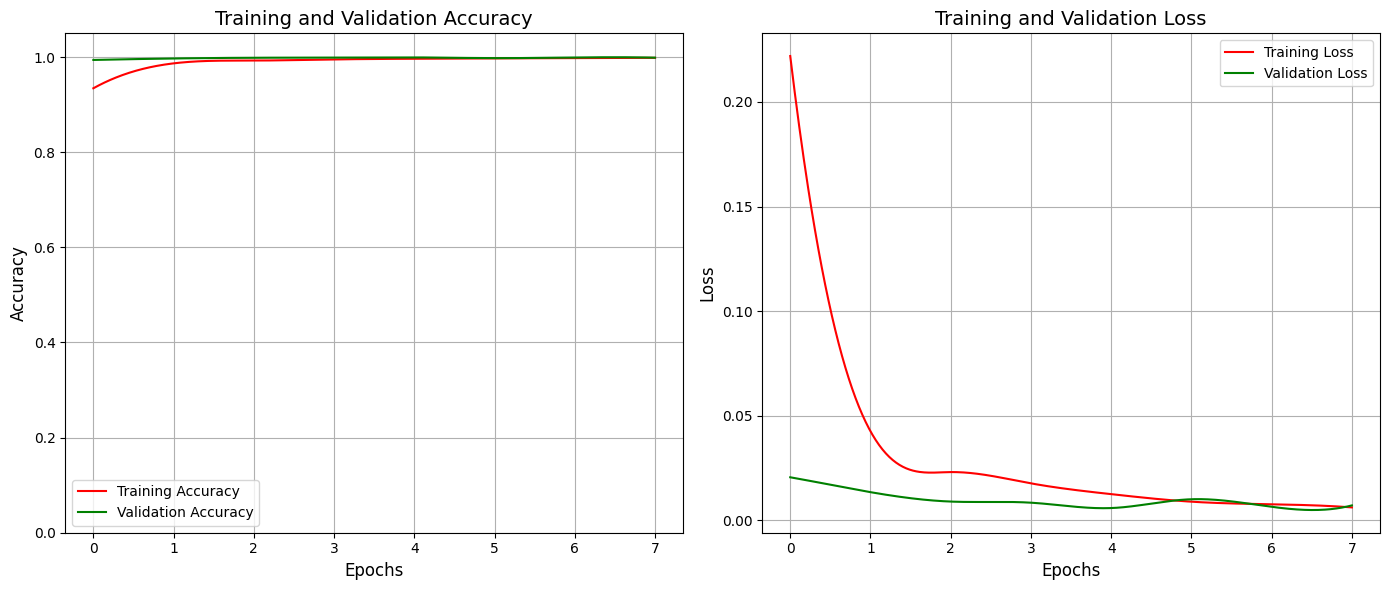

In [ ]:
# Plot Accuracy and Loss
results_plot_finetune = scoring(
    model_finetune, train_generator, val_generator, test_generator, return_type='plot',
    plot_path=f'FineTuned_{base_model}_Plot_Accuracy_Loss.png', history=history_finetune
)

Generating confusion matrix...
21/21 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step


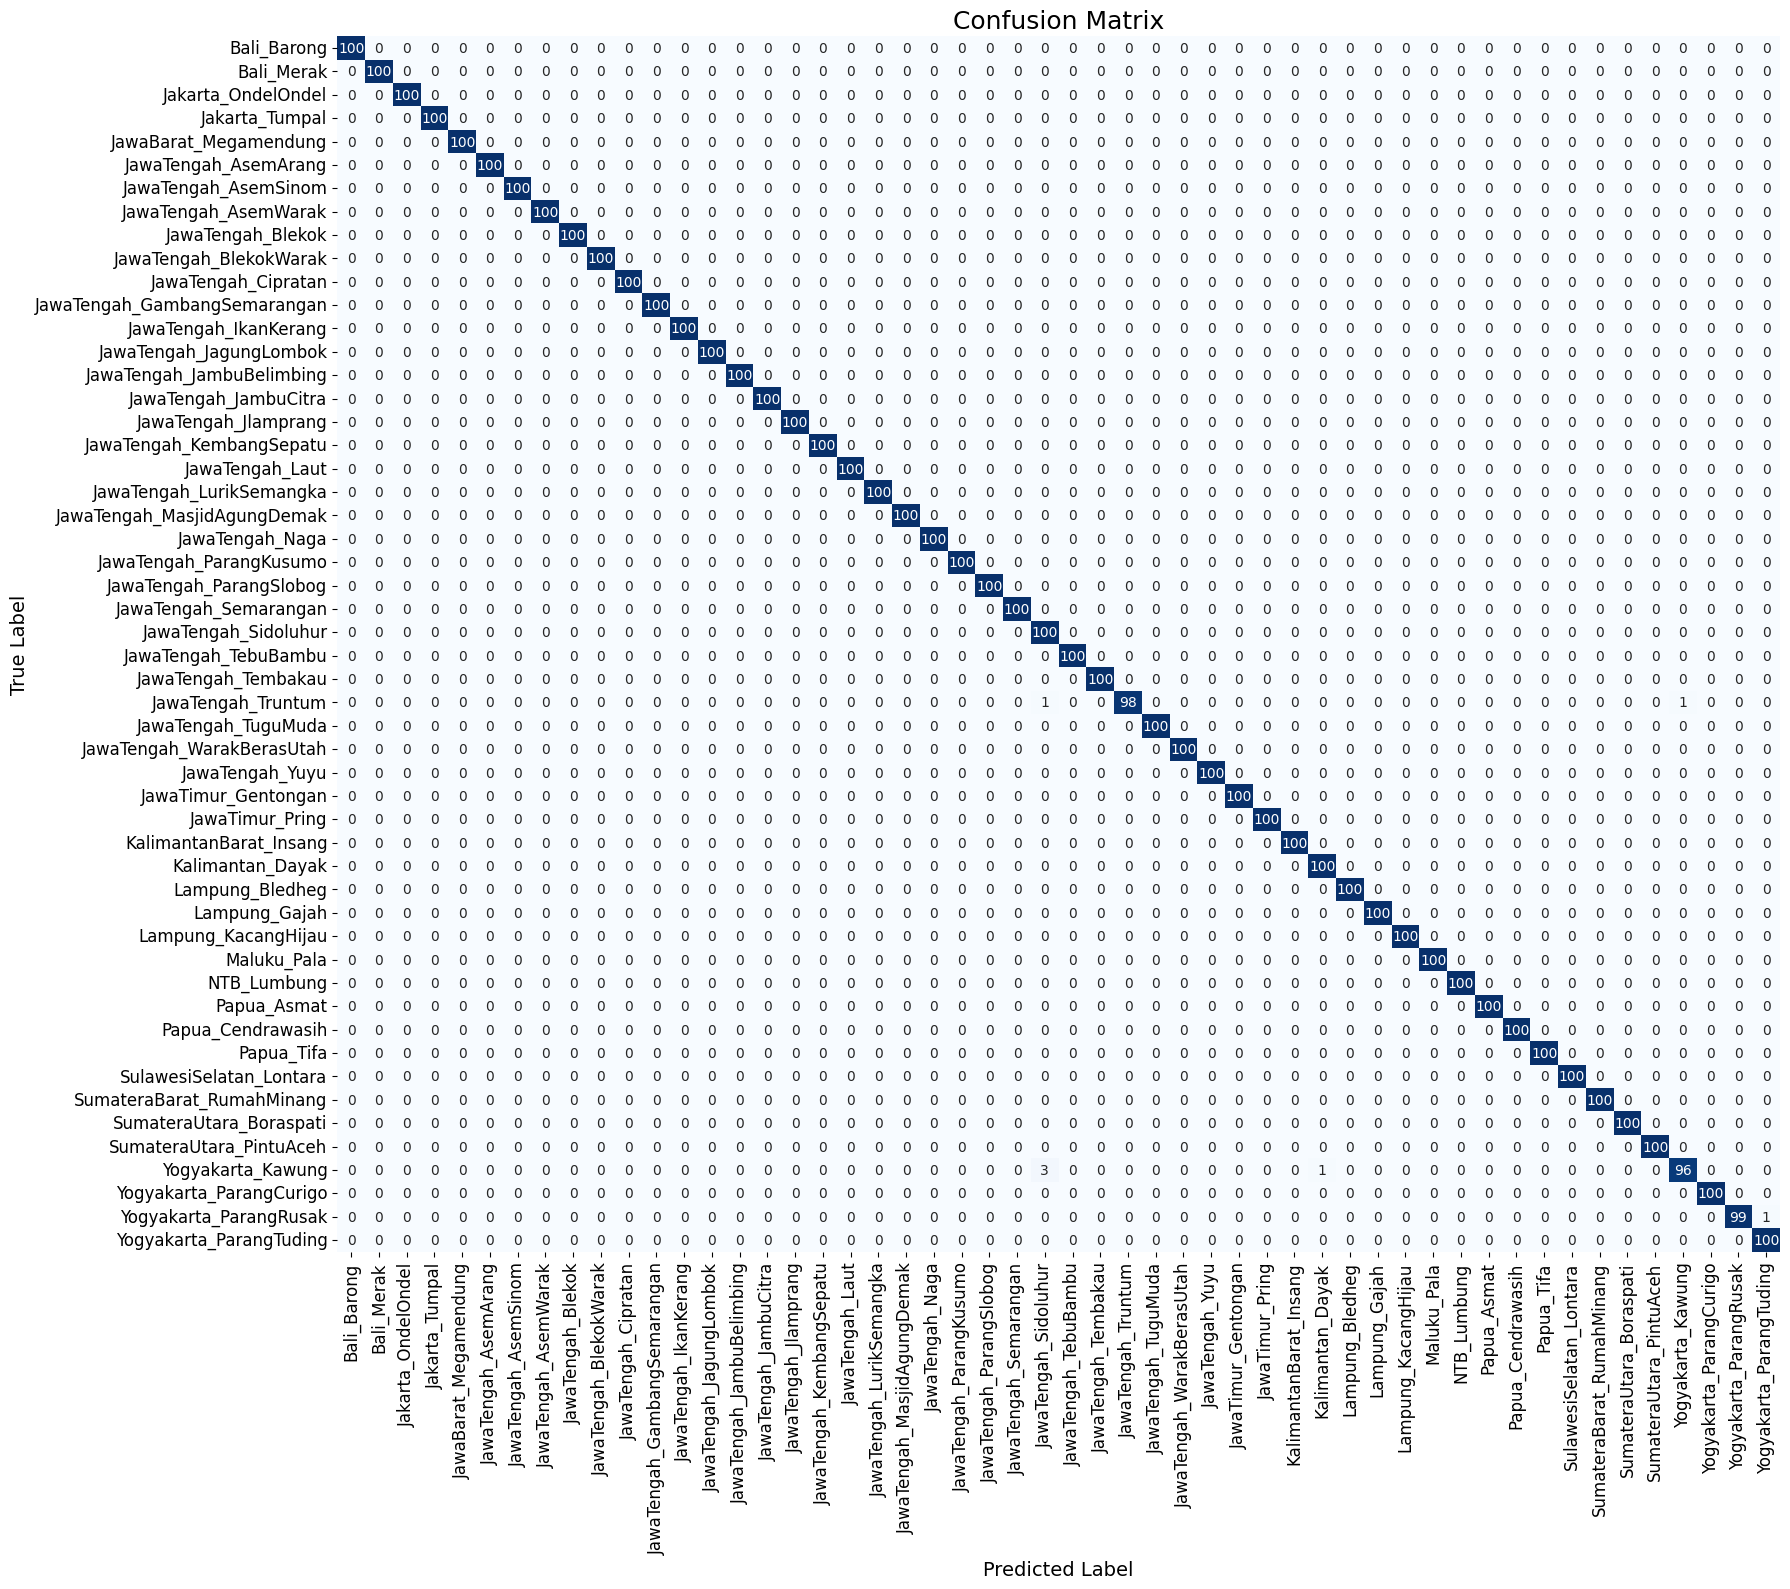

In [ ]:
# Confusion Matrix
results_cm_finetune = scoring(model_finetune, train_generator, val_generator, test_generator, return_type='cm', plot_path=f'FineTuned_{base_model}_Confusion_Matrix.png')

In [ ]:
# Classification Report
results_cr_finetune = scoring(model_finetune, train_generator, val_generator, test_generator, return_type='cr')

Classification Report:

21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step
                              precision    recall  f1-score   support

                 Bali_Barong       1.00      1.00      1.00       100
                  Bali_Merak       1.00      1.00      1.00       100
          Jakarta_OndelOndel       1.00      1.00      1.00       100
              Jakarta_Tumpal       1.00      1.00      1.00       100
       JawaBarat_Megamendung       1.00      1.00      1.00       100
        JawaTengah_AsemArang       1.00      1.00      1.00       100
        JawaTengah_AsemSinom       1.00      1.00      1.00       100
        JawaTengah_AsemWarak       1.00      1.00      1.00       100
           JawaTengah_Blekok       1.00      1.00      1.00       100
      JawaTengah_BlekokWarak       1.00      1.00      1.00       100
         JawaTengah_Cipratan       1.00      1.00      1.00       100
JawaTengah_GambangSemarangan       1.00      1.00      1.00       100
       JawaTengah_IkanKera

In [ ]:
# Predictions
results_predict_finetune = scoring(model_finetune, train_generator, val_generator, test_generator, return_type='pred')

Making predictions on test data...
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step
Accuracy on test data: 0.9987


In [ ]:
# Statistics
results_stats_finetune = scoring(model_finetune, train_generator, val_generator, test_generator, return_type='stat')

Calculating statistics...
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 981ms/step

Per-class Results:
                         Category  Correct  Incorrect  Accuracy (%)
0                    Bali_Barong      100          0         100.0
1                     Bali_Merak      100          0         100.0
2             Jakarta_OndelOndel      100          0         100.0
3                 Jakarta_Tumpal      100          0         100.0
4          JawaBarat_Megamendung      100          0         100.0
5           JawaTengah_AsemArang      100          0         100.0
6           JawaTengah_AsemSinom      100          0         100.0
7           JawaTengah_AsemWarak      100          0         100.0
8              JawaTengah_Blekok      100          0         100.0
9         JawaTengah_BlekokWarak      100          0         100.0
10           JawaTengah_Cipratan      100          0         100.0
11  JawaTengah_GambangSemarangan      100          0         100.0
12         JawaTengah_IkanKerang      10

In [ ]:
# results_all_finetune = scoring(model_finetune, train_generator, val_generator, test_generator, return_type='all')

# Plot Accuracy and Loss Combined

In [ ]:
def plot_combined_learning_curves(
    transfer_epochs, transfer_train_acc, transfer_val_acc, transfer_train_loss, transfer_val_loss,
    finetune_epochs, finetune_train_acc, finetune_val_acc, finetune_train_loss, finetune_val_loss,
    start_fine_tuning_epoch, file_name
):
    combined_epochs = list(transfer_epochs) + [e + max(transfer_epochs) + 1 for e in finetune_epochs]
    combined_train_acc = list(transfer_train_acc) + list(finetune_train_acc)
    combined_val_acc = list(transfer_val_acc) + list(finetune_val_acc)
    combined_train_loss = list(transfer_train_loss) + list(finetune_train_loss)
    combined_val_loss = list(transfer_val_loss) + list(finetune_val_loss)

    x = np.array(combined_epochs)
    x_smooth = np.linspace(x.min(), x.max(), 500)

    train_acc_smooth = make_interp_spline(x, combined_train_acc)(x_smooth)
    val_acc_smooth = make_interp_spline(x, combined_val_acc)(x_smooth)
    train_loss_smooth = make_interp_spline(x, combined_train_loss)(x_smooth)
    val_loss_smooth = make_interp_spline(x, combined_val_loss)(x_smooth)

    fig, axes = plt.subplots(2, 1, figsize=(10, 10))

    # Plot Training and Validation Accuracy
    axes[0].plot(x_smooth, train_acc_smooth, label='Training Accuracy', color='blue')
    axes[0].plot(x_smooth, val_acc_smooth, label='Validation Accuracy', color='orange')
    axes[0].axvline(x=start_fine_tuning_epoch, color='green', linestyle='--', label='Start Fine Tuning')
    axes[0].set_title('Training and Validation Accuracy', fontsize=14)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(loc='best', fontsize=10)
    axes[0].grid()

    # Plot Training and Validation Loss
    axes[1].plot(x_smooth, train_loss_smooth, label='Training Loss', color='blue')
    axes[1].plot(x_smooth, val_loss_smooth, label='Validation Loss', color='orange')
    axes[1].axvline(x=start_fine_tuning_epoch, color='green', linestyle='--', label='Start Fine Tuning')
    axes[1].set_title('Training and Validation Loss', fontsize=14)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(loc='best', fontsize=10)
    axes[1].grid()

    plt.tight_layout()
    plt.savefig(file_name)
    plt.show()

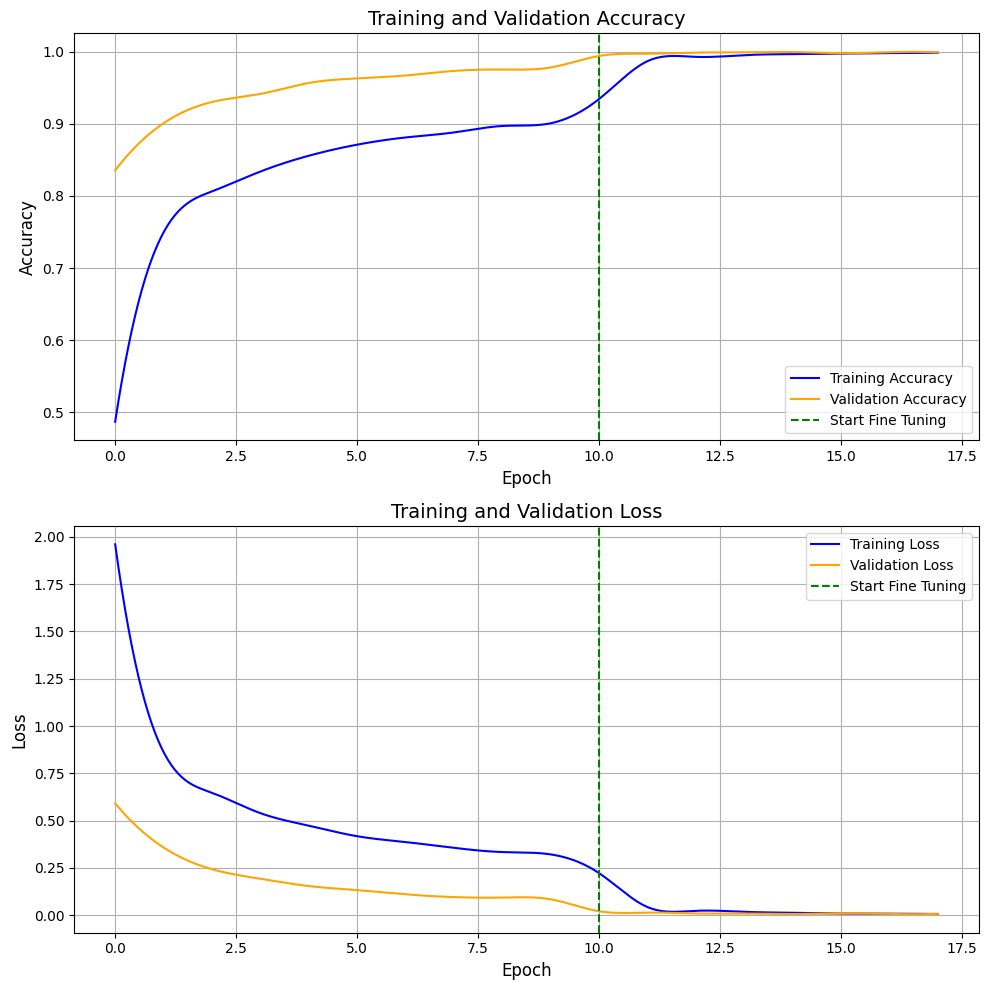

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(train_acc))

train_acc_finetune = history_finetune.history['accuracy']
val_acc_finetune = history_finetune.history['val_accuracy']
train_loss_finetune = history_finetune.history['loss']
val_loss_finetune = history_finetune.history['val_loss']
epochs_finetune = range(len(train_acc_finetune))

plot_combined_learning_curves(
    epochs, train_acc, val_acc, train_loss, val_loss,
    epochs_finetune, train_acc_finetune, val_acc_finetune, train_loss_finetune, val_loss_finetune,
    len(epochs), f'{base_model}_Plot_Accuracy_Loss_Combined.png'
)

# Image Prediction with Upload File

In [ ]:
def predict_image(model, img_size, regions, motifs):

    def load_and_preprocess_image(img_path, img_size):

        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        return img_array, img

    print("Upload your images...")
    uploaded = files.upload()

    for img_path in uploaded.keys():
        try:
            img_array, img = load_and_preprocess_image(img_path, img_size)

            prediction = model.predict(img_array)
            predicted_class = np.argmax(prediction)
            confidence = prediction[0][predicted_class]

            motif = motifs[predicted_class]
            region = regions[predicted_class]

            print(f"Image: {img_path}")
            print(f"Prediction: Motif {motif} (From: {region})")
            print(f"Confidence: {confidence * 100:.2f}%")

            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

In [ ]:
regions = [region for region, motif in [format_class_label(label) for label in list(test_generator.class_indices.keys())]]
motifs = [motif for region, motif in [format_class_label(label) for label in list(test_generator.class_indices.keys())]]

Upload your images...


Saving Motif-awan-mega-mendung.jpg to Motif-awan-mega-mendung.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Image: Motif-awan-mega-mendung.jpg
Prediction: Motif Megamendung (From: Jawa Barat)
Confidence: 100.00%


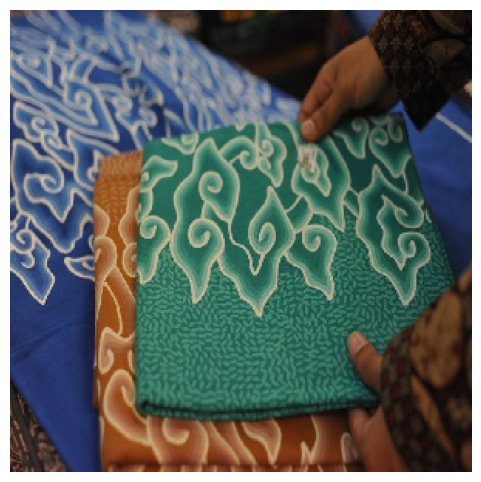

In [ ]:
predict_image(model_finetune, img_size, regions, motifs)

Upload your images...


Saving motif batik ondel ondel.jpg to motif batik ondel ondel.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Image: motif batik ondel ondel.jpg
Prediction: Motif Ondel Ondel (From: Jakarta)
Confidence: 99.99%


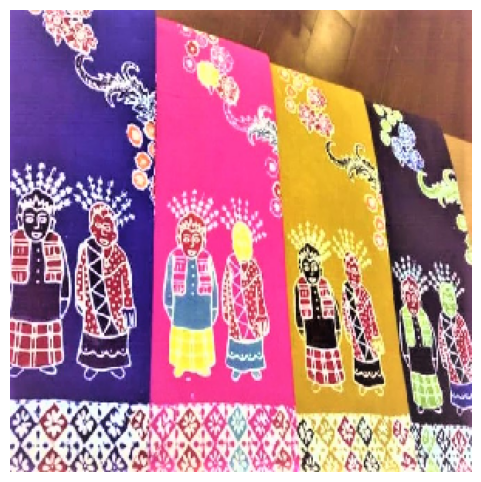

In [ ]:
predict_image(model_finetune, img_size, regions, motifs)

# Image Prediction by Taking Pictures

In [ ]:
from IPython.display import display, Javascript
from PIL import Image
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
def predict_image_from_camera(model, img_size, regions, motifs, filename='photo.jpg'):

    img = Image.open(filename)
    img = img.resize(img_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]

    motif = motifs[predicted_class]
    region = regions[predicted_class]

    print(f"Prediction: Motif {motif} (From: {region})")
    print(f"Confidence: {confidence * 100:.2f}%")

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

<IPython.core.display.Javascript object>

Saved to photo.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction: Motif Parang Rusak (From: Yogyakarta)
Confidence: 78.15%


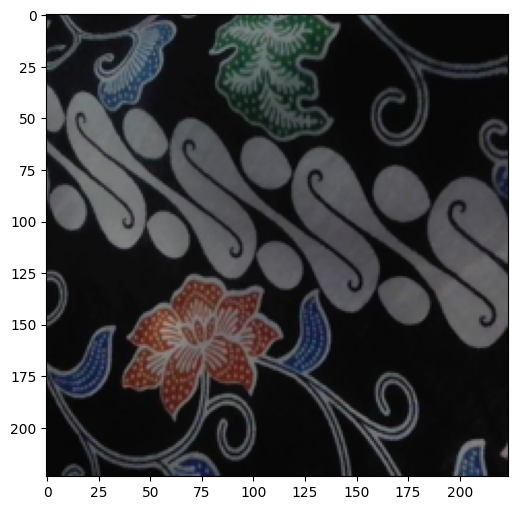

In [ ]:
try:
    filename = take_photo()
    print(f"Saved to {filename}")

    predict_image_from_camera(model_finetune, img_size, regions, motifs, filename)
except Exception as err:
    print(f"Error: {str(err)}")

# Convert to TFLite

In [ ]:
!pip install -q tflite-support

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 19.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.


In [ ]:
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

In [ ]:
while True:
    try:
        from tflite_support.metadata_writers import image_classifier, writer_utils, metadata_info
        from tensorflow_lite_support.metadata import metadata_schema_py_generated as _metadata_fb
        print("Libraries imported successfully.")
        break
    except Exception as e:
        print(f"An error occurred during import: {e}")
        print("Retrying in 2 seconds...")
        time.sleep(2)

An error occurred during import: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates
Retrying in 2 seconds...
Libraries imported successfully.


In [ ]:
!gdown --id 1LnSHeQgs4zEDsJ3aALlIC_2vPWQgciqj

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1fQ3vCtwEO4_bIbH0pcdFi1JANuS-KQfg
To: /content/labels.txt
100% 1.67k/1.67k [00:00<00:00, 8.92MB/s]


In [ ]:
def to_tflite(model, tflite_filename, label_file_path=None, optimizations=False):

    model = load_model(model)
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    if optimizations:
        converter.optimizations = [tf.lite.Optimize.DEFAULT]

    tflite_model = converter.convert()

    with open(tflite_filename, 'wb') as f:
        f.write(tflite_model)
    print(f"TFLite model saved at: {tflite_filename}")

    if label_file_path:
        if not os.path.exists(label_file_path):
            raise FileNotFoundError(f"Label file not found at: {label_file_path}")

        try:
            model_buffer = writer_utils.load_file(tflite_filename)

            general_md = metadata_info.GeneralMd(
                name="BatikLens",
                description=(
                    "Image classifier to identify 52 traditional batik patterns in Indonesia. "
                    f"The model uses transfer learning and fine-tuning with {base_model}."
                ),
                version="v1",
                author="C242-PS082",
                licenses="Apache License. Version 2.0")

            input_md = metadata_info.InputImageTensorMd(
                name="image",
                description=(
                    "Input image to be classified. The expected image is {0} x {1} pixels, "
                    "with three channels (red, blue, and green) per pixel. "
                    "Each value in the tensor is a single byte between 0 and 255.".format(width, height)
                ),
                norm_mean=[0.0],
                norm_std=[255.0],
                color_space_type=_metadata_fb.ColorSpaceType.RGB,
                tensor_type=writer_utils.get_input_tensor_types(model_buffer)[0]
                )

            output_md = metadata_info.ClassificationTensorMd(
                name="probability",
                description="Probabilities of the 52 batik patterns respectively.",
                label_files=[
                    metadata_info.LabelFileMd(file_path=label_file_path,
                                              locale="en")
                ],
                tensor_type=writer_utils.get_output_tensor_types(model_buffer)[0]
                )

            ImageClassifierWriter = image_classifier.MetadataWriter

            writer = ImageClassifierWriter.create_from_metadata_info(
                model_buffer, general_md, input_md, output_md)

            print(writer.get_metadata_json())

            output_model_path = tflite_filename.replace('.tflite', '_Metadata.tflite')
            writer_utils.save_file(writer.populate(), output_model_path)
            print(f"Metadata added successfully. Model with metadata saved at: {output_model_path}")
        except Exception as e:
            print(f"An error occurred while adding metadata: {e}")

    return tflite_filename

In [ ]:
model_path = f"/content/Final_FineTuned_{base_model}_Model.keras"
label_file_path = "/content/labels.txt"
tflite_filename = f"/content/BatikLens_{base_model}_Model.tflite"

tflite_model = to_tflite(model_path, tflite_filename, label_file_path=label_file_path)

Saved artifact at '/tmp/tmpgidxcygz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 52), dtype=tf.float32, name=None)
Captures:
  132431648052800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132431648061424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132431648063728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132431648059136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132431648057552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132431648073232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132431648074816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132431648070592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132431648077984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132431648113056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132431648077

# Testing TFLite Model

In [ ]:
def test_tflite_model(tflite_model_path, img_size, regions, motifs):

    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    print(f"Model Input Details: {input_details}")
    print(f"Model Output Details: {output_details}")

    print("\nUpload your images...")
    uploaded = files.upload()

    for img_path in uploaded.keys():
        try:
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img).astype(np.float32) / 255.0
            input_data = np.expand_dims(img_array, axis=0)

            interpreter.set_tensor(input_details[0]['index'], input_data)
            interpreter.invoke()

            output_data = interpreter.get_tensor(output_details[0]['index'])
            predicted_class = np.argmax(output_data)
            confidence = output_data[0][predicted_class]

            motif = motifs[predicted_class]
            region = regions[predicted_class]

            print(f"Image: {img_path}")
            print(f"Prediction: Motif {motif} (From: {region})")
            print(f"Confidence: {confidence * 100:.2f}%")

            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

Model Input Details: [{'name': 'serving_default_input_layer_1:0', 'index': 0, 'shape': array([  1, 299, 299,   3], dtype=int32), 'shape_signature': array([ -1, 299, 299,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Model Output Details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 322, 'shape': array([ 1, 52], dtype=int32), 'shape_signature': array([-1, 52], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]

Upload your images...


Saving batik-truntum.jpg to batik-truntum.jpg
Image: batik-truntum.jpg
Prediction: Motif Truntum (From: Jawa Tengah)
Confidence: 99.99%


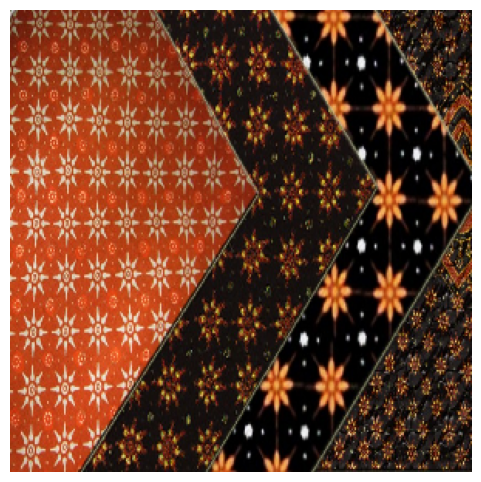

In [ ]:
model_path = f"/content/BatikLens_{base_model}_Model_Metadata.tflite"

test_tflite_model(model_path, img_size, regions, motifs)